In [ ]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex').to('cuda') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg').to('cuda') # closer to "traditional" perceptual loss, when used for optimization
def lpips(generated_images, targets):
    generated_images = generated_images.to('cuda')
    targets = targets.to('cuda')
    img0 = targets
    img1 = generated_images
    d = loss_fn_alex(img0, img1)
    return d

In [ ]:
import  torch
import  utils
import  models
import  dataset
import  os ,tqdm
import  numpy                               as      np
import  matplotlib.pyplot                   as      plt
#import  torchvision.models                  as      models
import  torchvision.transforms              as      transforms
from    torch.utils.data                    import  DataLoader
from    nltk.translate.bleu_score           import  sentence_bleu, SmoothingFunction
import dataset
from torch.utils.data import Subset
import warnings
import random
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore", category=UserWarning, module="skimage.feature.texture")
warnings.filterwarnings("ignore", category=UserWarning, message="The attention mask and the pad token id were not set")
warnings.filterwarnings("ignore", category=UserWarning, message="TypedStorage is deprecated")


directory_path      = r"/ssd1/HyunJun/SRCAP/models/training/LR=0.0001 d_out_mean=True batch_sizet=10 N_ROI=10 Fine_tuning=True"
model               = r"LR=0.0001 d_out_mean=True batch_sizet=10 N_ROI=10 Fine_tuning=True.pt"
#directory_path      = r"/ssd1/HyunJun/SRCAP/models/testing/LR=8e-05 Upscaling_factor= 4 d_out_mean=True batch_sizet=10 N_ROI=10 Fine_tuning=True"
#model               = r"LR=8e-05 Upscaling_factor= 4 d_out_mean=True batch_sizet=10 N_ROI=10 Fine_tuning=True.pt"
chencherry = SmoothingFunction()
dataDir='..'
dataType='test2017'
COCOdataset = dataset.train_dataset_version2(utils.root, utils.training_dataset_json.format(dataDir,dataType))
indices = list(range(100))
COCOdataset = Subset(COCOdataset, indices)
test_dataloader = DataLoader(dataset= COCOdataset, batch_size=10, shuffle=False, collate_fn=dataset.collate_fn_version2, num_workers= 15)

Tester = models.SRCAP_version2_Generator().to('cuda')
Tester.load_state_dict(torch.load(os.path.join(directory_path,model)))
Tester.eval()
scores          = [0,0,0,0]
count_failed    = [0,0,0,0]
count_sussec    = [0,0,0,0]
senteses = []
senteses_groundTruth = []
psnr_value = 0
lpips_value = 0
loop = tqdm.tqdm(
                            enumerate(test_dataloader, 1),
                            total=len(test_dataloader),
                            desc="BLEU",
                            position=0,
                            leave=True
                        )

with torch.inference_mode():
    for batch_idx, (img_real, img, anns) in loop:
        image_real = img_real.to('cuda')
        img = img.to('cuda')
        anns = anns.to('cuda')
#img : low-resolution image, img_real : high-resolution image, fake_img : super-resolved low-resolution image, real_anns : label annotations, fake_anns: annotations generated from super-resolved image, real_anns: annotations generated from high resolution image
        for index in range(utils.batch_size):
            fake_img, fake_anns = Tester(img, "Generator")
            real_anns = Tester.process_and_tokenizer(img).to('cuda')
            real_anns_tokenizer = utils.load("tokenizer").batch_decode(real_anns[index],  skip_special_tokens=True)
            anns_tokenizer = utils.load("tokenizer").batch_decode(anns[index], skip_special_tokens =True)
            fake_anns_tokenizer = utils.load("tokenizer").batch_decode(fake_anns[index], skip_special_tokens = True)

            try:
                scores[0] += sentence_bleu(["".join(anns_tokenizer),], "".join(fake_anns_tokenizer) , weights = (1,0,0,0), smoothing_function=chencherry.method4)
                count_sussec[0] +=1
            except:
                count_failed[0] += 1

            try:
                scores[1] += sentence_bleu(["".join(anns_tokenizer),], "".join(fake_anns_tokenizer), weights = (0.5,0.5,0,0), smoothing_function=chencherry.method4)
                count_sussec[1] +=1
            except:
                count_failed[1] += 1

            try:
                scores[2] += sentence_bleu(["".join(anns_tokenizer),], "".join(fake_anns_tokenizer),weights = (0.333,0.333,0.334,0),smoothing_function=chencherry.method4)
                count_sussec[2] +=1
            except:
                count_failed[2] += 1

            try:
                scores[3] += sentence_bleu(["".join(anns_tokenizer),], "".join(fake_anns_tokenizer),weights = (0.25,0.25,0.25,0.25),smoothing_function=chencherry.method4)
                count_sussec[3] +=1
            except:
                count_failed[3] += 1

            loop.set_description(f"iteration : {batch_idx}")
            loop.set_postfix(
                BLEU_1 = f"{(np.array(scores)/np.array(count_sussec))[0]:.4f}",
                BLEU_2 = f"{(np.array(scores)/np.array(count_sussec))[1]:.4f}",
                BLEU_3 = f"{(np.array(scores)/np.array(count_sussec))[2]:.4f}",
                BLEU_4 = f"{(np.array(scores)/np.array(count_sussec))[3]:.4f}",
                PSNR = f"{utils.psnr(fake_img, image_real): 4f}",
                LPIPS = f"{(sum(lpips(fake_img, image_real))/utils.batch_size).item(): 4f}",
                refresh=True,
            )
            psnr_value += utils.psnr(fake_img, image_real)
            lpips_value += sum(lpips(fake_img, image_real))/utils.batch_size

    print(np.array(scores)/np.array(count_sussec), psnr_value/len(indices), (lpips_value.item())/len(indices))

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


iteration : 10: 100%|██████████| 10/10 [04:03<00:00, 24.33s/it, BLEU_1=0.6803, BLEU_2=0.5418, BLEU_3=0.4540, BLEU_4=0.3948, LPIPS=0.284972, PSNR=23.735504]

[0.68034984 0.5417702  0.45404436 0.39480184] 25.903276726026256 0.2449364471435547


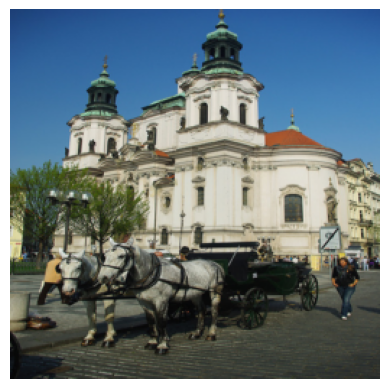

In [ ]:
plt.axis('off')
plt.imshow(img_real[0].permute(1,2,0).cpu().detach().numpy())

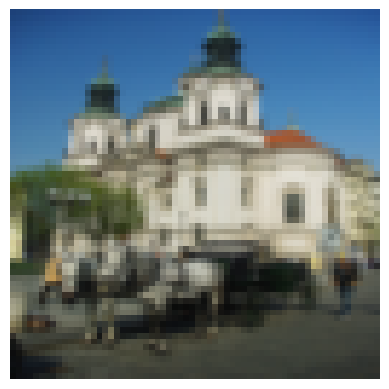

In [ ]:
plt.axis('off')
plt.imshow(img[0].permute(1,2,0).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


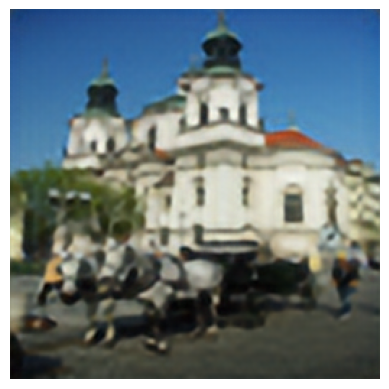

In [ ]:
plt.axis('off')
plt.imshow(fake_img[0].permute(1,2,0).cpu().detach().numpy())

In [ ]:
print(utils.load("tokenizer").batch_decode(anns[0],  skip_special_tokens=True)) #Original img caption

['A', ' horse', ' drawn', ' carriage', ' is', ' parked', ' along', ' the', ' curb', '.']


In [ ]:
real_anns = Tester.process_and_tokenizer(img_real).to('cuda')
print(utils.load("tokenizer").batch_decode(real_anns[0],  skip_special_tokens=True)) #HR img caption

['a', ' horse', ' drawn', ' carriage', ' is', ' driving', ' down', ' the', ' street', ' ']


In [ ]:
real_anns = Tester.process_and_tokenizer(img).to('cuda')
print(utils.load("tokenizer").batch_decode(real_anns[0],  skip_special_tokens=True)) #LR img caption

['a', ' street', ' scene', ' with', ' a', ' horse', ' drawn', ' carriage', ' ', '']


In [ ]:
print(utils.load("tokenizer").batch_decode(fake_anns[0],  skip_special_tokens=True)) #SR img caption

['a', ' horse', ' drawn', ' carriage', ' is', ' driving', ' down', ' the', ' street', ' ']


In [ ]:
import  torch
import  utils
import  models
import  dataset
import  os ,tqdm
import  numpy                               as      np
import  matplotlib.pyplot                   as      plt
#import  torchvision.models                  as      models
import  torchvision.transforms              as      transforms
from    torch.utils.data                    import  DataLoader
from    nltk.translate.bleu_score           import  sentence_bleu, SmoothingFunction
import dataset
from torch.utils.data import Subset
import warnings
import random
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore", category=UserWarning, module="skimage.feature.texture")
warnings.filterwarnings("ignore", category=UserWarning, message="The attention mask and the pad token id were not set")
warnings.filterwarnings("ignore", category=UserWarning, message="TypedStorage is deprecated")


# directory_path      = r"/ssd1/HyunJun/SRCAP/models/testing/LR=0.0002 d_out_mean=True batch_sizet=10 N_ROI=10 Fine_tuning=True"
# model               = r"LR=0.0002 d_out_mean=True batch_sizet=10 N_ROI=10.pt"
directory_path      = r"/ssd1/HyunJun/SRCAP/models"
model               = r"SRResNet.pt"
chencherry = SmoothingFunction()
dataDir='..'
dataType='test2017'
COCOdataset = dataset.train_dataset_version2(utils.root, utils.training_dataset_json.format(dataDir,dataType))
indices = list(range(100))
COCOdataset = Subset(COCOdataset, indices)
test_dataloader = DataLoader(dataset= COCOdataset, batch_size=10, shuffle=False, collate_fn=dataset.collate_fn_version2, num_workers= 15)
psnr_value = 0
Tester = models.SRResNet().to('cuda')
Tester.load_state_dict(torch.load(os.path.join(directory_path,model)))
Tester.eval()
scores          = [0,0,0,0]
count_failed    = [0,0,0,0]
count_sussec    = [0,0,0,0]
senteses = []
senteses_groundTruth = []

loop = tqdm.tqdm(
                            enumerate(test_dataloader, 1),
                            total=len(test_dataloader),
                            desc="BLEU",
                            position=0,
                            leave=True
                        )

with torch.inference_mode():
    for batch_idx, (img_real, img, anns) in loop:
        image_real = img_real.to('cuda')
        img = img.to('cuda')
        anns = anns.to('cuda')
#img : low-resolution image, img_real : high-resolution image, fake_img : super-resolved low-resolution image, real_anns : label annotations, fake_anns: annotations generated from super-resolved image, real_anns: annotations generated from high resolution image
        for index in range(utils.batch_size):
            fake_img = Tester(img)
            fake_anns = models.SRCAP_version2_Generator().process_and_tokenizer(fake_img).to('cuda')
            anns_tokenizer = utils.load("tokenizer").batch_decode(anns[index], skip_special_tokens =True)
            fake_anns_tokenizer = utils.load("tokenizer").batch_decode(fake_anns[index], skip_special_tokens = True)

            try:
                scores[0] += sentence_bleu(["".join(anns_tokenizer),], "".join(fake_anns_tokenizer) , weights = (1,0,0,0), smoothing_function=chencherry.method4)
                count_sussec[0] +=1
            except:
                count_failed[0] += 1

            try:
                scores[1] += sentence_bleu(["".join(anns_tokenizer),],"".join(fake_anns_tokenizer), weights = (0.5,0.5,0,0), smoothing_function=chencherry.method4)
                count_sussec[1] +=1
            except:
                count_failed[1] += 1

            try:
                scores[2] += sentence_bleu(["".join(anns_tokenizer),], "".join(fake_anns_tokenizer),weights = (0.333,0.333,0.334,0),smoothing_function=chencherry.method4)
                count_sussec[2] +=1
            except:
                count_failed[2] += 1

            try:
                scores[3] += sentence_bleu(["".join(anns_tokenizer),],"".join(fake_anns_tokenizer),weights = (0.25,0.25,0.25,0.25),smoothing_function=chencherry.method4)
                count_sussec[3] +=1
            except:
                count_failed[3] += 1


            loop.set_description(f"iteration : {batch_idx}")
            loop.set_postfix(
                BLEU_1 = f"{(np.array(scores)/np.array(count_sussec))[0]:.4f}",
                BLEU_2 = f"{(np.array(scores)/np.array(count_sussec))[1]:.4f}",
                BLEU_3 = f"{(np.array(scores)/np.array(count_sussec))[2]:.4f}",
                BLEU_4 = f"{(np.array(scores)/np.array(count_sussec))[3]:.4f}",
                PSNR = f"{utils.psnr(fake_img, image_real): 4f}",
                refresh=True,
            )
            psnr_value += utils.psnr(fake_img, image_real)

    print(np.array(scores)/np.array(count_sussec), psnr_value/len(indices))

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


iteration : 10: 100%|██████████| 10/10 [02:20<00:00, 14.10s/it, BLEU_1=0.6515, BLEU_2=0.4955, BLEU_3=0.3940, BLEU_4=0.3296, PSNR=19.416559]

[0.65147582 0.49552026 0.39402914 0.32958339] 21.35039339800648


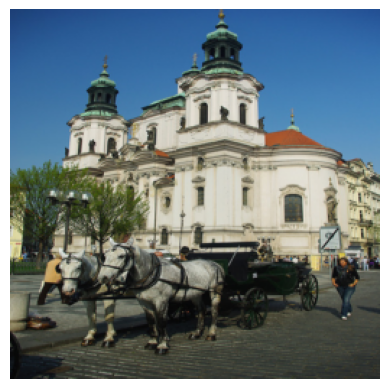

In [ ]:
plt.axis('off')
plt.imshow(img_real[0].permute(1,2,0).cpu().detach().numpy())

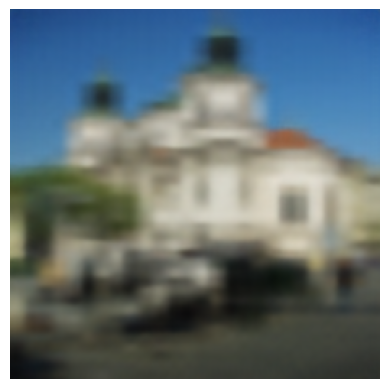

In [ ]:
plt.axis('off')
plt.imshow(fake_img[0].permute(1,2,0).cpu().detach().numpy())

In [ ]:
print(utils.load("tokenizer").batch_decode(anns[0],  skip_special_tokens=True)) #Original img caption

['A', ' horse', ' drawn', ' carriage', ' is', ' parked', ' along', ' the', ' curb', '.']


In [ ]:
print(utils.load("tokenizer").batch_decode(fake_anns[0],  skip_special_tokens=True)) #SR img caption

['a', ' street', ' scene', ' with', ' a', ' horse', ' drawn', ' carriage', ' ', '']


In [ ]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex').to('cuda') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg').to('cuda') # closer to "traditional" perceptual loss, when used for optimization
def lpips(generated_images, targets):
    generated_images = generated_images.to('cuda')
    targets = targets.to('cuda')
    d = loss_fn_alex(generated_images, targets)
    return d
print(fake_img.shape)
print("SR_img : ", sum(lpips(fake_img, img_real))/utils.batch_size)